<a href="https://colab.research.google.com/github/zzcn23/Unit2ExcercisesCannon/blob/main/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

If we only have one model, there's no benchmark to compare the elpd_loo. For instance, a more positive elpd_loo only has significance if another model has a lower elpd_loo, conveying that the first is a better predictor. Additionally, without another model to compare the standard error to, we don't know how the performance is.

**Task2**:

Describe overfitting, in the context of this course

Overfitting is when we have too many variables and too much unnecessary information that ends up distracting the model from detecting the underlying pattern we want to find.

**Task3**:

How do we mitigate overfitting?

We mitigate overfitting by using priors. Weak priors or regularizing priors allow for a more effective model with less redundancy.

**Task4**:

How do we mitigate underfitting?

We can mitigate underfitting by using elpd_loo to select a more accurate model. A low elpd_loo score signals poor predictive fit and maybe underfitting, so choosing a higher score can solve underfitting.

**Task5**:

Why would we want more than one predictor in a model?

More than one predictor can help a model capture relationships in the data and improve predictive accuracy.

**Task6**:

Can we have too many predictors? How would we now?

Too many predictors could led to overfitting and redundant information that distracts the model. It could lead to a slower model, letting us know to decrease predictors. We could also use elpd loo to find a model with the right balance of predictors. We should generally have a bias towards simpler models to help with overfitting and interpretation.

**Task7**:

What is variable selection, and how does it work?

We do variable selection, which is deciding which variables to include in a model to predict another variable, based on casual DAGS. These diagrams help us determine relationships between variables so we can decide what to include or exclude from a model. This diagram can also help us uncover interactions between variables so we can include that in our model.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

A linear regression model with two predictors (one being a categorical variable) assumes the same slope or same efect across all categories while a hierarchical model captures category specific effects and slope while sharing information across categories. A model with interaction included accounts for different effects of the variable on the categories but doesn't pool informtion like the hierarchical model.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

We visualize multiple linear regressin models with multiple graphs and compare them with metrics like elpd_loo. Models with two preedictors can be visualized easily with a 2D graph. As the number of predictors increases though, it becomes impossible to visualize the model on one plot all at once.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb
import xarray as xr

In [24]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()

In [66]:
# Only look at players who played more than 600 minutes
bb = bb.query('MP > 600')

# Remove players who never missed a free throw
bb = bb[bb['FTp'] != 1.0]  # Changed from query() to standard filtering

# Filter out the combo positions for clearer graphs
bb = bb.query("Pos in ['C', 'PF', 'SF', 'SG', 'PG']")

# Rename columns to remove the '%' sign
bb.rename(columns={"FT%": "FTp", "FG%": "FGp"}, inplace=True)


#Categorical

In [6]:
#define the model
model_basketball = bmb.Model("`FGp` ~ `FTp` + Pos", data=bb)
#fit the model
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

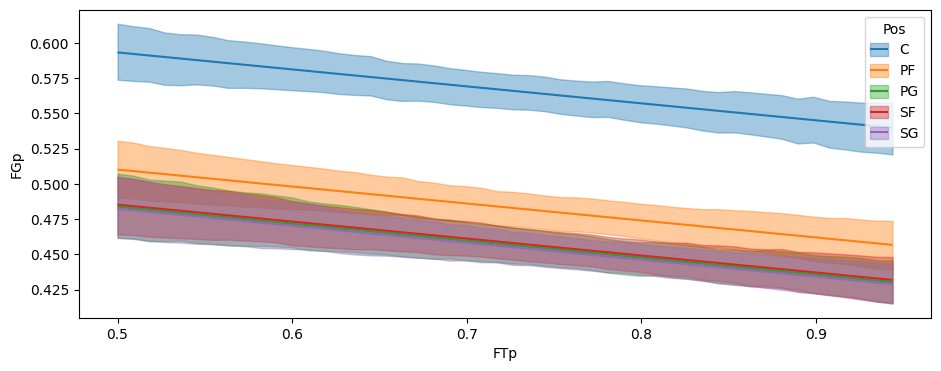

In [7]:
#plot 94% HDIs of the means of each position
bmb.interpret.plot_predictions(model_basketball,
                               idata_basketball,
                                ["FTp",  "Pos"], fig_kwargs={"figsize":(11, 4)})

#Hierarchical

In [8]:
#define the model, but as a hierarchy
model_basketball_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
#create the model
idata_basketball_h = model_basketball_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

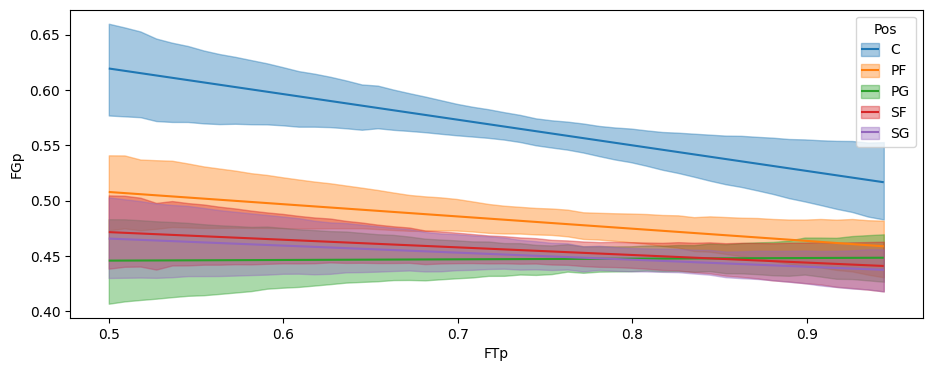

In [9]:
bmb.interpret.plot_predictions(model_basketball_h,
                               idata_basketball_h,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

#Interaction

In [11]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
#create the model
idata_bb_inter = model_bb_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='FTp', ylabel='FGp'>], dtype=object))

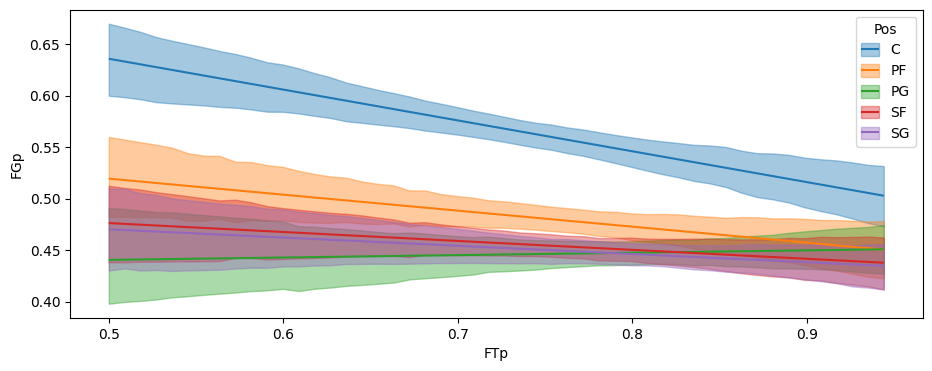

In [12]:
bmb.interpret.plot_predictions(model_bb_inter,
                               idata_bb_inter,
                               ["FTp","Pos"],
                               fig_kwargs={"figsize":(11, 4)})

#3 variables- interactions all

In [67]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter2 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA`+ `FTp`:Pos+ 'FTp':'3PA'+ Pos:'3PA'", data=bb)
#create the model
idata_bb_inter2 = model_bb_inter2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

#3 variables- 2 interactions

In [69]:
#define the model; bb_inter stands for baskeball interaction
model_bb_inter3 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA`+ Pos:'3PA'", data=bb)
#create the model
idata_bb_inter3 = model_bb_inter3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

# Compare


In [70]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"1":idata_basketball,"2":idata_basketball_h, "3":idata_bb_inter,"4":idata_bb_inter2, "5":idata_bb_inter3} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,529.486394,13.072516,0.000000,5.623477e-01,15.859699,0.000000,False,log
4,1,528.793432,19.283729,0.692962,4.376523e-01,14.978793,3.765718,True,log
3,2,509.563878,13.658257,19.922516,5.016689e-14,16.651638,7.597051,False,log
2,3,508.271070,14.093880,21.215324,2.473409e-14,17.072322,7.169634,False,log
1,4,507.266464,8.315035,22.219930,0.000000e+00,16.051419,6.781563,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

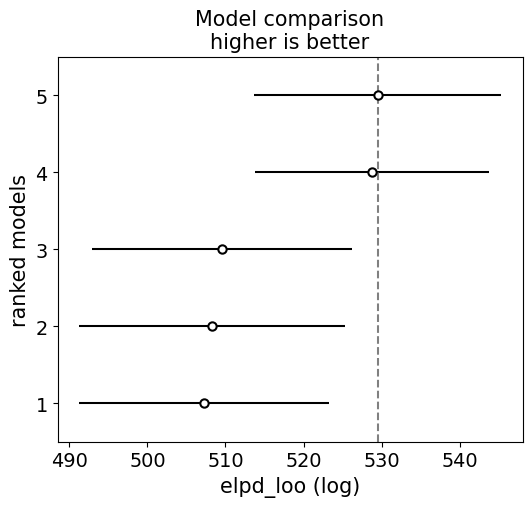

In [71]:
az.plot_compare(cmp_df)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

Model 4 and 5 appear to be better according to elpd_loo because they have higher values. I think this makes sense because they're accounting for interaction between variables- allowing the model to capture more complex relationships and make better predictions. However, all the standard error bars overlap in the graph which means all the models could perform similarly for predictive purposes when given new data. In order to help determine the best model you'd have to reference a casual diagram too.